In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
from tqdm import trange

In [2]:
import sys
from generate_data import make_data
from SWGG import get_SWGG_smooth,SWGG_smooth,SWGG_parallel
from utils import random_slice,sort_to_plan

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


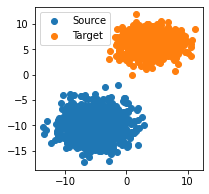

In [28]:
n=1000
dim=2
xs,xt=make_data('gaussians',n,dim)


X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)
X=X.float()
Y=Y.float()

pl.figure(figsize=(3,3))
pl.scatter(xs[:, 0], xs[:, 1], c='C0', label='Source')
pl.scatter(xt[:, 0], xt[:, 1], c='C1', label='Target')
pl.legend(loc=2)

# Exact $W^2_2$ distance

In [29]:
ns=xs.shape[0]
nt=xt.shape[0]
a, b = np.ones((ns,))/nt, np.ones((nt,))/nt
#The exact Wasserstein distance
C=ot.dist(xs,xt)
print('W = ',ot.emd2(a,b,C))

W =  339.33060896235776


# $SWGG^2_2$ Monte-Carlo

In [30]:
n_proj=20
theta=random_slice(n_proj,dim).T

In [31]:
#minS
W,u,v=SWGG_parallel(X,Y,theta)
P_l=[sort_to_plan(u[:,i],v[:,i]) for i in range(n_proj)]
print('SWGG = ',torch.min(W))
idx=torch.argmin(W)
P=sort_to_plan(u[:,idx],v[:,idx])

SWGG =  tensor(346.7201)


# $SWGG_2^2$ Optimization of the direction

In [32]:
num_iter=200
lr=1e-1
s=20
std=.5

t,loss_smooth_l,proj_smooth_l = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
theta_optim=t/torch.norm(t)

res_smooth=SWGG_smooth(X,Y,theta_optim,s=1,std=0)
print('minS with selected theta',res_smooth)

100%|████████████████████████| 200/200 [00:00<00:00, 264.64it/s, loss = 354.334]


minS with selected theta tensor(346.8968)


Text(0.5, 1.0, 'Choosen direction')

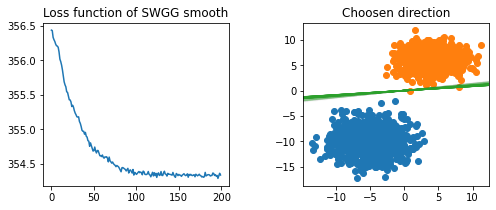

In [33]:
pl.figure(figsize=(8,3))
grid = pl.GridSpec(1, 2, wspace=0.4, hspace=0.3)

pl.subplot(grid[0, 0])
pl.plot(loss_smooth_l)
pl.title('Loss function of SWGG smooth')

pl.subplot(grid[0, 1])
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
for i in range(num_iter):
    pl.axline((0,0), list(proj_smooth_l[i,0:2]), color='C2',alpha=(i/num_iter)**10)
pl.title('Choosen direction')